# Audio classification using convolutional neural networks

Audio classification can be performed by converting audio streams into [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which provide visual representations of spectrums of frequencies as they vary over time, and classifying the spectrograms using [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs). 

This notebook is an adaptation of https://github.com/jeffprosise/Deep-Learning/blob/master/Audio%20Classification%20(CNN).ipynb


## Generate spectrograms


The first step is to load the WAV files, use a Python package named [Librosa](https://librosa.org/) to generate spectrogram images from them, load the spectrograms into memory, and prepare them for use in training a CNN. To aid in this process, we'll define a pair of helper functions for creating spectrograms from WAV files and converting all the WAV files in a specified directory into spectrograms.

In [1]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

## Generate spectrograms with labels

The next cell contains a variation from create_spectrogram and create_pngs_from_wavs functions, these variations add frecuency and time labels  for the spectrograms, though the training is done without them, labeled images can be used for better visual representation

In [ ]:
def create_labeled_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig, ax = plt.subplots(figsize=(8, 4))
    img = librosa.display.specshow(log_ms, sr=sr, x_axis="time", y_axis="mel", ax=ax)

    # Add labels
    ax.set_xlabel("Time (s)", fontsize=12)
    ax.set_ylabel("Frequency (Hz)", fontsize=12)
    fig.savefig(image_file)
    plt.close(fig)
    
def create_labeled_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_labeled_spectrogram(input_file, output_file)

Create PNG files containing spectrograms from all the WAV files in the "spanish" directory.

In [ ]:
create_pngs_from_wavs('spanish', 'spanish_spectrograms')

Create PNG files containing spectrograms from all the WAV files in the "mayan" directory.

In [ ]:
create_pngs_from_wavs('mayan', 'mayan_spectrograms')

Define two new helper functions for loading and displaying spectrograms and declare two Python lists — one to store spectrogram images, and another to store class labels.

In [3]:
from keras.preprocessing import image

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

Load the spanish spectrogram images, add them to the list named `x`, and label them with 0s.

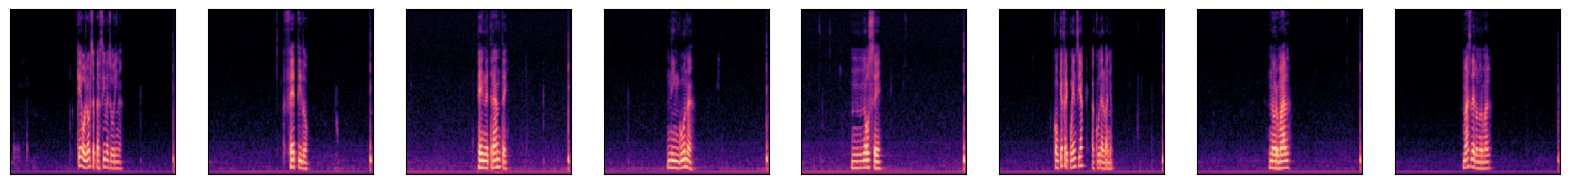

In [4]:
images, labels = load_images_from_path('spanish_spectrograms', 0)
show_images(images)
    
x += images
y += labels

Load the mayan spectrogram images, add them to the list named `x`, and label them with 1s.

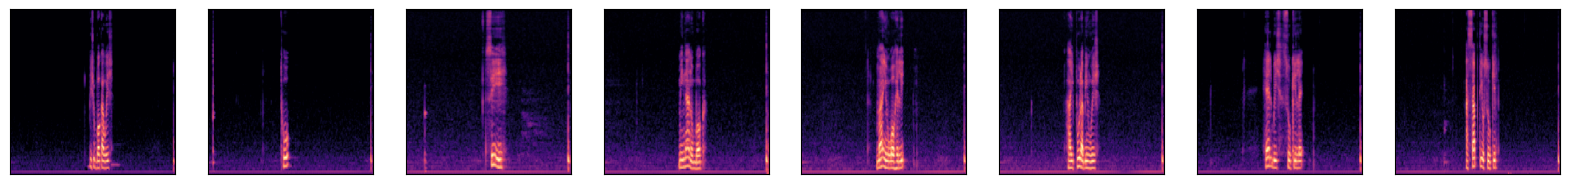

In [5]:
images, labels = load_images_from_path('mayan_spectrograms', 1)
show_images(images)
    
x += images
y += labels

Split the images and labels into three datasets — one for training, one for testing, and one for validation. Then divide the pixel values by 255 and one-hot-encode the labels using Keras's [to_categorical](https://keras.io/api/utils/python_utils/#to_categorical-function) function.

In [6]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


# Split data into training (80%) and a combined group for training and validation (20%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, stratify=y, test_size=0.2, random_state=0)

# Split the combined group (x_temp) into validation and trainig
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=0)


x_train_norm = np.array(x_train) / 255
x_val_norm = np.array(x_val) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

## Build and train a CNN with transfer learning

State-of-the-art image classification typically isn't done with traditional neural networks. Rather, it is performed with convolutional neural networks that use [convolution layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) to extract features from images and [pooling layers](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/) to downsize images so features can be detected at various resolutions. The next task is to build a CNN containing a series of convolution and pooling layers for feature extraction, a pair of fully connected layers for classification, and a `softmax` layer that outputs probabilities for each class, and to train it with spectrogram images and labels. Start by defining the CNN.

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated CNNs trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. Many pretrained CNNs are available in the public domain, and several are included with Keras. Let's use [`MobileNetV2`](https://keras.io/api/applications/mobilenet/), a pretrained CNN from Google that is optimized for mobile devices, to extract features from spectrogram images.

> `MobileNetV2` requires less processing power and has a smaller memory footprint than CNNs such as `ResNet50V2`. That's why it is ideal for mobile devices. You can learn more about it in the [Google AI blog](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html).

Start by calling Keras's [MobileNetV2](https://keras.io/api/applications/mobilenet/) function to instantiate `MobileNetV2` without the classification layers. Use the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input) function for `MobileNet` networks to preprocess the training and testing images. Then run both datasets through `MobileNetV2` to extract features.

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x_train_norm = preprocess_input(np.array(x_train))
x_test_norm = preprocess_input(np.array(x_test))
x_val_norm = preprocess_input(np.array(x_val))

train_features = base_model.predict(x_train_norm)
test_features = base_model.predict(x_test_norm)
val_features = base_model.predict(x_val_norm)

96/96 ━━━━━━━━━━━━━━━━━━━━ 55s 552ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step


Define a neural network to classify features extracted by `MobileNetV2`.

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Flatten(input_shape=train_features.shape[1:]))
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\jeanb\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    64,226,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,228,354 (245.01 MB)

 Trainable params: 64,228,354 (245.01 MB)

 Non-trainable params: 0 (0.00 B)

Train the network with features extracted by `MobileNetV2`.

In [9]:
hist = model.fit(train_features, y_train_encoded, validation_data=(test_features, y_test_encoded), batch_size=10, epochs=10)



Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 156s 507ms/step - accuracy: 0.7859 - loss: 8.4677 - val_accuracy: 0.8665 - val_loss: 0.2838
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 154s 503ms/step - accuracy: 0.9281 - loss: 0.1740 - val_accuracy: 0.8874 - val_loss: 0.2793
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 155s 507ms/step - accuracy: 0.9618 - loss: 0.1008 - val_accuracy: 0.8403 - val_loss: 0.4197
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 153s 498ms/step - accuracy: 0.9598 - loss: 0.0944 - val_accuracy: 0.8822 - val_loss: 0.3798
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 154s 502ms/step - accuracy: 0.9658 - loss: 0.1003 - val_accuracy: 0.8586 - val_loss: 0.5451
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 153s 500ms/step - accuracy: 0.9697 - loss: 0.0809 - val_accuracy: 0.8691 - val_loss: 0.6743
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 153s 499ms/step - accuracy: 0.9810 - loss: 0.0544 - val_accuracy: 0.8770 - val_loss: 0.4139
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 153s 499ms/step - accuracy: 0.9650 -

Plot the training and validation accuracy.

[]

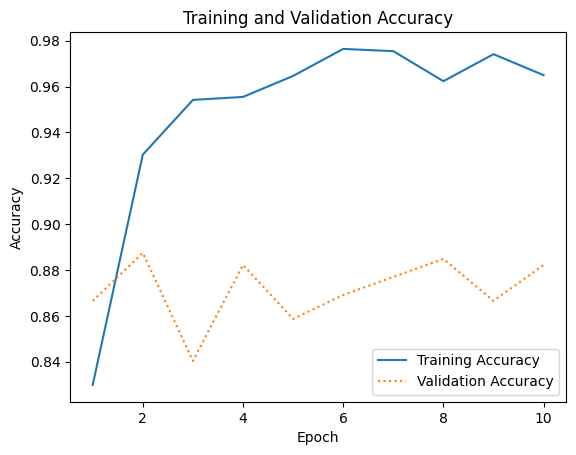

In [10]:

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Run the validation images through the network and use a confusion matrix to assess the results.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Text(110.44999999999997, 0.5, 'Actual label')

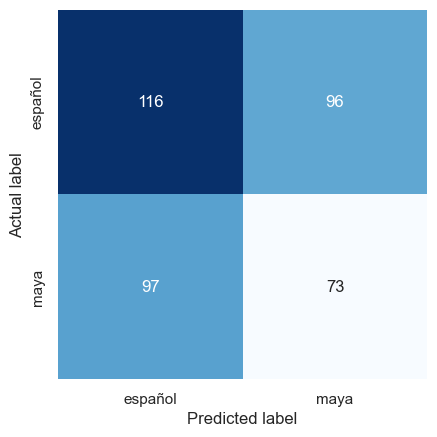

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(val_features)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['español', 'maya']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Get accuracy, recall, precision and f1 score metrics

In [12]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np

y_pred = model.predict(test_features)

y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Accuracy: 0.8821989528795812
Recall: 0.8588235294117647
Precision: 0.874251497005988
F1 Score: 0.8664688427299704


# Saving additional info
Training is done and we have the metrics, so next we can save the model and the split in case we need that information

# Save the model
Saving it as a .keras file, allows you use the trained model in the future

In [ ]:
model.save("model.keras")

# Save the split
Save the split by first creating the subfolders where the splitted images (train, test, validation) will be store

In [ ]:
import os

# Create directories
base_dir = 'split'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, "validation")

# Make subfolders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir,exist_ok=True)


Use save_images function to save the splitted images to their respective subfolder, creating a subfolder for each class in the process

NOTE: The images are saved from the array used in the training so original picture names are lost

In [ ]:
from PIL import Image
import numpy as np
import os

def save_images(image_list, labels, target_dir):
    for idx, (image_array, label) in enumerate(zip(image_list, labels)):
        label = str(label)

        # Create subfolder for class
        class_dir = os.path.join(target_dir, label)
        os.makedirs(class_dir, exist_ok=True)


        image = Image.fromarray(image_array.astype(np.uint8)) 

        image_path = os.path.join(class_dir, f"image_{idx}.png")
        image.save(image_path)





save_images(x_train, y_train, train_dir)
save_images(x_test, y_test, test_dir)
save_images(x_val, y_val, val_dir)